In [144]:
import pandas as pd
import pybedtools as pyb
from Bio import SeqIO
from pylab import *
import glob
import seaborn as sns
from seaborn import distplot
import pickle
from matplotlib_venn import venn3, venn3_circles
from itertools import groupby, count
from collections import Counter

Downloaded coding sequences from http://www.arabidopsis.org and ran TRF 

In [4]:
TRF_OUTPUT = '../data/TAIR10_cds_20101214_updated.trf.output' # Tandem repeats finder output
BED_OUTPUT = '../data/TAIR10_cds_20101214_updated.trf.output.BED'

Making BED files from TRF output

In [5]:
fh = open(TRF_OUTPUT, 'r')
TRF = fh.read()
fh.close()

# Making dictionary with each gene as a key and the repeats within the gene in a list
TRF_dict = {}
for i in TRF.split('@'):
    split = i.split('\n')
    if split != ['']:
        gene = str(split).split('|')[0].replace('[\'', '').replace('["', '').replace(' ', '')
        repeats = split[1:len(split) - 1]
        repeat_list = []
        for repeat in repeats:
            #if repeat.split()[2] == str(3):
                repeat_list.append(repeat.split(' ')[0:2])
        TRF_dict.update({gene : repeat_list})
        
# Making BED file
fh = open(BED_OUTPUT, 'w')
string = ''

tab = '\t'
for i in TRF_dict.keys():
    for k in TRF_dict[i]:
        start = (int(k[0]) -1) / 3
        end = (int(k[1])) / 3
        string += i + tab + str(start) + tab + str(end) + tab + 'STR' + tab + '+' + '\n'
fh.write(string)
fh.close()

Function to "clean" data, avoiding duplicate coordinates in different transcripts in the same gene. This would bias stats later on.

In [195]:
def clean(data, name):
    # Writing output of intersect to file
    fh = open('../data/unclean_data_%s.tsv' % name, 'w')
    tab = '\t'
    newline = '\n'
    string = 'GENE' + tab + 'START' + tab + 'END' + tab + 'FEATURE' + newline
    for i in data:
        string += i[0] + tab + str(i[1]) + tab + str(i[2]) + tab + i[3] + newline
    fh.write(string)
    fh.close()

    # Doing the manipulations with pandas
    df = pd.read_table('../data/unclean_data_%s.tsv' % name)
    df['GENE2'] = [i.split('.')[0] for i in df.GENE]
    df = df.drop_duplicates(subset = ['GENE2', 'START', 'END'])

    # Writing the dataframe to BED
    fh = open('../data/clean_data_%s.bed' % name, 'w')
    string = ''
    for i in df.itertuples():
        string += str(i[1]) + tab + str(i[2]) + tab + str(i[3]) + tab + str(i[4]) + newline
    fh.write(string)
    fh.close()

    return pyb.BedTool('../data/clean_data_%s.bed' % name)

Loading BED

In [7]:
STRs = pyb.BedTool(BED_OUTPUT)

In [8]:
cSTRs = clean(STRs, 'STRs')

Making dictionary with protein lengths for stats later

In [188]:
ID_list = []
for i in cSTRs:
    ID_list.append(i[0])

string = ''
dictionary = {}
for record in SeqIO.parse('../data/TAIR10_pep_20101214.txt', 'fasta'):
    if record.id in ID_list:
        dictionary.update({record.id : (0, len(record.seq))})
        
cSTRs.set_chromsizes(dictionary)

<BedTool(clean_data_STRs.bed)>

### DisoRDPbind

Splitting into bulks of 5000 as this is the limit of what the webservice at http://biomine.cs.vcu.edu/servers/DisoRDPbind/ accepts.

In [14]:
!mkdir ../data/FASTA_SEQUENCES/

In [15]:
def batch_iterator(iterator, batch_size):
    """Returns lists of length batch_size.

    This can be used on any iterator, for example to batch up
    SeqRecord objects from Bio.SeqIO.parse(...), or to batch
    Alignment objects from Bio.AlignIO.parse(...), or simply
    lines from a file handle.

    This is a generator function, and it returns lists of the
    entries from the supplied iterator.  Each list will have
    batch_size entries, although the final list may be shorter.
    """
    entry = True  # Make sure we loop once
    while entry:
        batch = []
        while len(batch) < batch_size:
            try:
                entry = iterator.next()
            except StopIteration:
                entry = None
            if entry is None:
                # End of file
                break
            batch.append(entry)
        if batch:
            yield batch

record_iter = SeqIO.parse(open("../data/TAIR10_pep_20101214.txt"),"fasta")
for i, batch in enumerate(batch_iterator(record_iter, 5000)):
    filename = "../data/FASTA_SEQUENCES/TAIR10_pep_20101214_%i.fasta" % (i + 1)
    with open(filename, "w") as handle:
        count = SeqIO.write(batch, handle, "fasta")
    print("Wrote %i records to %s" % (count, filename))

Wrote 5000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_1.fasta
Wrote 5000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2.fasta
Wrote 5000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_3.fasta
Wrote 5000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_4.fasta
Wrote 5000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_5.fasta
Wrote 5000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_6.fasta
Wrote 5000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_7.fasta
Wrote 386 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_8.fasta


Concatenating results downloaded from webservice

In [20]:
! cat ../data/DisoRDPbind_Results/*.DisoRDPbind.results* > ../data/DisoRDPbind_Results/DisoRDPbind.results.txt

Making BED file from DisoRDPbind output

In [19]:
# Making BED file from DisorDPbind output
def make_bed_from_disordbind(DisoRDPbind_output, filename, prot_dna_rna):
    gene_lst = []
    fh = open(filename, 'w')
    tab = '\t'
    newline = '\n'
    for i in sorted(DisoRDPbind_output.split('>')):
        if i != '':
            gene_part = i.split()[0].replace('_', '.').replace('..Symbol', '')[:-1]
            transcript_n = i.split()[0].replace('_', '.').replace('..Symbol', '')[-1]
            
            gene = gene_part + '.' + transcript_n
                 
            if prot_dna_rna == 'Protein':
                bin_prot = [p for p in i.split('\n')[6].split(':')[1]]

                AA_pos = 0
                merge_list = []
                for pos in bin_prot:
                    AA_pos += 1
                    if pos == '1':
                        merge_list.append(AA_pos)

            if prot_dna_rna == 'DNA':
                dna = [d for d in i.split('\n')[4].split(':')[1]]
                AA_pos = 0
                merge_list = []
                for pos in dna:
                    AA_pos += 1
                    if pos == '1':
                        merge_list.append(AA_pos)

            if prot_dna_rna == 'RNA':
                rna = [r for r in i.split('\n')[2].split(':')[1]]
                AA_pos = 0
                merge_list = []
                for pos in rna:
                    AA_pos += 1
                    if pos == '1':
                        merge_list.append(AA_pos)


            range_dict = {}
            ind_range = []
            for e in merge_list:
                if e + 1 in merge_list or e - 1 in merge_list:
                    ind_range.append(e)
                    range_dict.update({gene : ind_range})

            if range_dict != {}:
                for lst in range_dict.values():
                    L = lst
                    groups = groupby(L, key=lambda item, c=count():item-next(c))
                    tmp = [list(g) for k, g in groups]
                    for i in tmp:
                        gene_lst.append(gene)
                        fh.write(gene + tab + str(i[0] - 1)  + tab + str(i[-1]) + tab + prot_dna_rna + newline)
    return gene_lst
    fh.close()

In [22]:
# Output from DisoRDPbind
fh = open('../data/DisoRDPbind_Results/DisoRDPbind.results.txt', 'r')
DisoRDPbind = fh.read()
fh.close()

# Making BED files of PPI, DPI and RPI
for I in ['Protein', 'DNA', 'RNA']:
    make_bed_from_disordbind(DisoRDPbind, '../data/DisoRDPbind_Results/DisorDPbind_%s.bed' % I, I)

Loading BED files

In [23]:
Protein = pyb.BedTool('../data/DisoRDPbind_Results/DisorDPbind_Protein.bed')
DNA = pyb.BedTool('../data/DisoRDPbind_Results/DisorDPbind_DNA.bed')
RNA = pyb.BedTool('../data/DisoRDPbind_Results/DisorDPbind_RNA.bed')

cProtein = clean(Protein, 'Protein')
cDNA = clean(DNA, 'DNA')
cRNA = clean(RNA, 'RNA')

## ANCHOR

Loading ANCHOR data downloaded from d2p2

In [24]:
anchor = pd.read_table('../data/anchor.disrange', header = None, names = ['d2p2_ID', 'AA_start', 'AA_stop','N'])

Table to map d2p2 IDs with TAIR IDs

In [27]:
Arab_map = pd.read_table('../data/genomes.protein.at', sep = ' ', header = None, names = ['TAIR_ID', 'd2p2_ID'])
Arab_anchor = pd.merge(anchor, Arab_map)

Making BED of ANCHOR file

In [28]:
fh = open('../data/Arab_anchor.bed', 'w')
string = ''
tab = '\t'
newline = '\n'
for i in Arab_anchor.itertuples():
    string += i.TAIR_ID + tab + str(i.AA_start - 1) + tab + str(i.AA_stop) + tab + 'ANCHOR' + newline
fh.write(string)
fh.close()

Loading BED

In [29]:
Arab_anchor_bed = pyb.BedTool('../data/Arab_anchor.bed')

In [56]:
cArab_anchor_bed = clean(Arab_anchor_bed, 'Arab_anchor_bed')

## DFLpred

In [30]:
!mkdir ../data/DFLpred_Results/

Loading output

In [31]:
DFLpred = ''
for filename in glob.glob('../data/DFLpred_Results/*.DFLpred.results*'):
    fh = open(filename, 'r')
    DFLpred += fh.read() + '\n'
    fh.close()
    
fh = open('../data/DFLpred.results.txt', 'w')
fh.write(DFLpred)
fh.close()

fh = open('../data/DFLpred.results.txt', 'r')
DFLpred = fh.read()
fh.close()

Making BED

In [33]:
def make_bed_from_DFLpred(DFLpred, filename):
    gene_lst = []
    tab = '\t'
    newline = '\n'
    fh = open(filename, 'w')

    for i in DFLpred.split('>'):
        if i != '':

            gene_part = i.split()[0].replace('__Symbol', '')[:-1]
            transcript_n = i.split()[0].replace('__Symbol', '')[-1]

            gene = gene_part + '.' + transcript_n

            s = i.split('\n')[2].split(',')

            if s[-1] == ',':
                s = s[:-1]
            if s[-1] == '':
                s = s[:-1]
            try:
                scores = [float(score) for score in s]
            except:
                print s

            AA_pos = 0
            merge_list = []
            for pos in scores:
                AA_pos += 1
                if pos > 0.18:
                    merge_list.append(AA_pos)



            range_dict = {}
            ind_range = []
            for e in merge_list:
                if e + 1 in merge_list or e - 1 in merge_list:
                    ind_range.append(e)
                    range_dict.update({gene : ind_range})

            if range_dict != {}:
                for lst in range_dict.values():
                    L = lst
                    groups = groupby(L, key=lambda item, c=count():item-next(c))
                    tmp = [list(g) for k, g in groups]
                    for i in tmp:
                        gene_lst.append(gene)
                        fh.write(gene + tab + str(i[0] - 1)  + tab + str(i[-1]) + tab + 'DFL' + newline)
    fh.close()

In [34]:
make_bed_from_DFLpred(DFLpred, '../data/DFLpred.results.bed')

In [35]:
DFLpred_bed = pyb.BedTool('../data/DFLpred.results.bed')

In [36]:
cDFLpred_bed = clean(DFLpred_bed, 'DFLpred')

## MoRFpred

The server can only take 2000 proteins at the same time

In [37]:
record_iter = SeqIO.parse(open("../data/TAIR10_pep_20101214.txt"),"fasta")
for i, batch in enumerate(batch_iterator(record_iter, 2000)):
    filename = "../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_%i.fasta" % (i + 1)
    with open(filename, "w") as handle:
        count = SeqIO.write(batch, handle, "fasta")
    print("Wrote %i records to %s" % (count, filename))

Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_1.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_2.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_3.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_4.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_5.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_6.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_7.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_8.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_9.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_10.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_11.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAIR10_pep_20101214_2000_12.fasta
Wrote 2000 records to ../data/FASTA_SEQUENCES/TAI

Making BED of data

In [48]:
def make_bed_from_MoRFpred(MoRFpred, filename):
    gene_lst = []
    tab = '\t'
    newline = '\n'
    fh = open(filename, 'w')

    for i in MoRFpred.split('>'):
        if i != '':

            gene_part = i.split()[0].replace('__Symbol', '').replace('_Symbol', '')[:-1]
            transcript_n = i.split()[0].replace('__Symbol', '').replace('_Symbol', '')[-1]

            gene = gene_part + '.' + transcript_n
            s = i.split('\n')[3]

            if s[-1] == ',':
                s = s[:-1]
            if s[-1] == '':
                s = s[:-1]
            try:
                scores = [float(score) for score in s]
            except:
                print s

            AA_pos = 0
            merge_list = []
            for pos in scores:
                AA_pos += 1
                if pos == 1:
                    merge_list.append(AA_pos)



            range_dict = {}
            ind_range = []
            for e in merge_list:
                if e + 1 in merge_list or e - 1 in merge_list:
                    ind_range.append(e)
                    range_dict.update({gene : ind_range})

            if range_dict != {}:
                for lst in range_dict.values():
                    L = lst
                    groups = groupby(L, key=lambda item, c=count():item-next(c))
                    tmp = [list(g) for k, g in groups]
                    for i in tmp:
                        gene_lst.append(gene)
                        fh.write(gene + tab + str(i[0] - 1)  + tab + str(i[-1]) + tab + 'MoRF' + newline)
    fh.close()

In [39]:
!mkdir ../data/fMoRFpred_Results/

In [49]:
MoRFpred = ''
for filename in glob.glob('../data/fMoRFpred_Results/*.fMoRFpred.results*'):
    fh = open(filename, 'r')
    MoRFpred += fh.read() + '\n'
    fh.close()

In [52]:
from itertools import groupby, count

In [54]:
make_bed_from_MoRFpred(MoRFpred, '../data/fMoRFpred.results.bed')
MoRFpred_bed = pyb.BedTool('../data/fMoRFpred.results.bed')
cMoRFpred_bed = clean(MoRFpred_bed, 'MoRFpred')

Pickling

In [57]:
pickle.dump(cSTRs, open('../data/cSTRs.txt', 'w'))
pickle.dump(cProtein, open('../data/cProtein.txt', 'w'))
pickle.dump(cDNA, open('../data/cDNA.txt', 'w'))
pickle.dump(cRNA, open('../data/cRNA.txt', 'w'))
pickle.dump(cArab_anchor_bed, open('../data/cArab_anchor_bed.txt', 'w'))
pickle.dump(cDFLpred_bed, open('../data/cDFLpred_bed.txt', 'w'))
pickle.dump(cDisorder, open('../data/cDisorder.txt', 'w'))
pickle.dump(cMoRFpred_bed, open('../data/cMoRFpred_bed.txt', 'w'))

In [58]:
cSTRs = pickle.load(open('../data/cSTRs.txt', 'r'))
cProtein = pickle.load(open('../data/cProtein.txt', 'r'))
cDNA = pickle.load(open('../data/cDNA.txt', 'r'))
cRNA = pickle.load(open('../data/cRNA.txt', 'r'))
cArab_anchor_bed = pickle.load(open('../data/cArab_anchor_bed.txt', 'r'))
cDFLpred_bed = pickle.load(open('../data/cDFLpred_bed.txt', 'r'))
cDisorder = pickle.load(open('../data/cDisorder.txt', 'r'))
cMoRFpred_bed = pickle.load(open('../data/cMoRFpred_bed.txt', 'r'))

### D2P2

In [18]:
Disorder = pyb.BedTool('../data/Arab_disorder.bed')
cDisorder = clean(Disorder, 'Disorder')

Doing stats

In [59]:
iterations = 1000
res_PPI = cSTRs.randomstats(cProtein, iterations, shuffle_kwargs = {'chrom' : True})
res_DPI = cSTRs.randomstats(cDNA, iterations, shuffle_kwargs = {'chrom' : True})
res_RPI = cSTRs.randomstats(cRNA, iterations, shuffle_kwargs = {'chrom' : True})
res_ANCHOR = cSTRs.randomstats(cArab_anchor_bed, iterations, shuffle_kwargs = {'chrom' : True})
res_DFL = cSTRs.randomstats(cDFLpred_bed, iterations, shuffle_kwargs = {'chrom' : True})
res_Disorder = cSTRs.randomstats(cDisorder, iterations, shuffle_kwargs = {'chrom' : True})
res_MoRF = cSTRs.randomstats(cMoRFpred_bed, iterations, shuffle_kwargs = {'chrom' : True})

both = cProtein.intersect(cArab_anchor_bed)
res_A_P = cSTRs.randomstats(both, iterations, shuffle_kwargs = {'chrom' : True})

In [60]:
raw_results = []
percentiles = []
actuals = []
for res in [res_PPI, res_MoRF, res_ANCHOR, res_DPI, res_RPI, res_DFL, res_Disorder]:
    raw_results.append(res['actual'] / res['median randomized'])
    percentiles.append(res['percentile'])
    actuals.append(res['actual'])

## Supplementary figure 3d. - Distribution of features along proteins

Function the get position relative to protein length

In [177]:
def get_continous_dist(BED, name):
    dist = []
    for i in BED:
        if i[0] in dictionary.keys():
            mid = ((float(i[1]) + float(i[2])) / 2)
            length = dictionary[i[0]][1]
            d = mid / length
            if d > 1.0:
                print i[0], (float(i[1]), float(i[2])), length
            else:
                dist.append(d)
                
    return dist

Running function

In [191]:
fig1 = get_continous_dist(cSTRs, 'STRs')
fig2 = get_continous_dist(cProtein, 'Protein interaction sites')
fig3 = get_continous_dist(cDNA, 'DNA interaction sites')
fig4 = get_continous_dist(cRNA, 'RNA interaction sites')
fig5 = get_continous_dist(cArab_anchor_bed, 'ANCHOR sites')
fig6 = get_continous_dist(cDFLpred_bed, 'Disordered flexible linkers')
fig8 = get_continous_dist(cMoRFpred_bed, 'MoRF')

Plotting

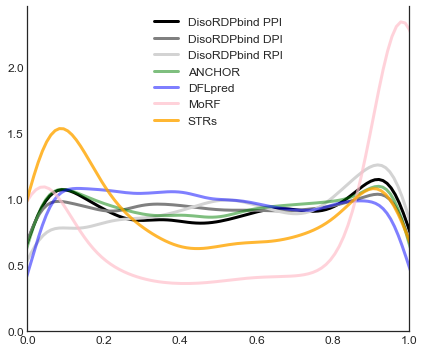

In [193]:
fig, ax = subplots(figsize = (6,5))
lw = 3
sns.set_style('white')

distplot(fig2, hist = False, kde_kws = {"color": "black", "lw": lw, 'label' : 'DisoRDPbind PPI', 'alpha' : 1})
distplot(fig3, hist = False, kde_kws = {"color": "gray", "lw": lw, 'label' : 'DisoRDPbind DPI', 'alpha' : 1})
distplot(fig4, hist = False, kde_kws = {"color": "lightgray", "lw": lw, 'label' : 'DisoRDPbind RPI', 'alpha' : 1})
distplot(fig5, hist = False, kde_kws = {"color": "green", "lw": lw, 'label' : 'ANCHOR', 'alpha' : 0.5})
distplot(fig6, hist = False, kde_kws = {"color": "blue", "lw": lw, 'label' : 'DFLpred', 'alpha' : 0.5})
distplot(fig8, hist = False, kde_kws = {"color": "pink", "lw": lw, 'label' : 'MoRF', 'alpha' : 0.7})


distplot(fig1, hist = False, kde_kws = {"color": "Orange", "lw": lw, 'label' : 'STRs', 'alpha' : 0.8})

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax.spines["top"].set_visible(False)
xlim(0, 1)
ylim(0)
legend(fontsize = 12)

tight_layout()

savefig('../Figures/Arabidopsis_Site_Distributions.png', type = 'png', dpi = 500, transparent = True)
savefig('../Figures/Arabidopsis_Site_Distributions.pdf', type = 'pdf', transparent = True)

show()

### Supplementary Figure 3c. Enrichment with disordered binding sites

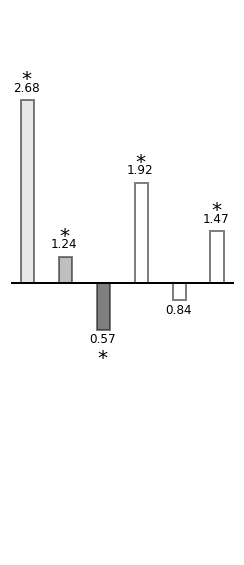

In [72]:
counter = -1
results = []
labels = ['DisoRDPbind PPI', 'MoRF', 'ANCHOR', 'DisoRDPbind DPI', 'DisoRDPbind RPI', 'DFLpred', 'Disorder']
for res in [res_PPI, res_MoRF, res_ANCHOR, res_DPI, res_RPI, res_DFL]:
    r = res['actual'] / res['median randomized']
    if r < 1:
        r = -(1 - r)
    else:
        r = r - 1
    results.append(r)
    
f, ax = subplots(figsize = (4,10))
rects = ax.bar([0,1,2,3,4,5], results, 0.35, linewidth = 2, edgecolor = 'black', color = ['lightgray', 'gray', 'black', 'white', 'white', 'white', 'white'], alpha = 0.5)

for rect in [rects]:
    for re in rect:
        counter += 1
        height = re.get_height()
        text = round(raw_results[counter], 2)
        actual = actuals[counter]
        
        if counter in [0,1,3,5,6]:
            ax.text(re.get_x() + 0.15, height + 0.05,
                    '%s' % text, ha='center', va='bottom', size = 12, color = 'black')
        else:
            ax.text(re.get_x() + 0.15, height - 0.15,
                    '%s' % text, ha='center', va='bottom', size = 12, color = 'black')
        if counter in [0,1,3,5,6]:
            ax.text(re.get_x() + 0.15, height + 0.1,
                    '*', ha='center', va='bottom', size = 20, color = 'black')
        if counter in [2]:
            ax.text(re.get_x() + 0.15, height - 0.35,
                    '*', ha='center', va='bottom', size = 20, color = 'black')

ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.axhline(0, linewidth=2, color='Black')
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.xaxis.set_ticks([-2])
ax.yaxis.set_ticks([200])


ylim(-2.5, 2.5)

savefig('../Figures/Arabidopsis_Enrichments.png', type = 'png', dpi = 300, transparent = True)
savefig('../Figures/Arabidopsis_Enrichments.pdf', type = 'pdf', transparent = True)

show()

Overlap between PPI sites

### Figure 3.b

In [73]:
tool1 = cSTRs.intersect(cMoRFpred_bed, wa = True)
tool2 = cSTRs.intersect(cProtein, wa = True)
tool3 = cSTRs.intersect(cArab_anchor_bed, wa = True)

sets = []
for tool in [tool1, tool2, tool3]:
    sets.append(set([x[0].split('.')[0] + '_' + str(x[1]) + '_' + str(x[2]) for x in tool]))

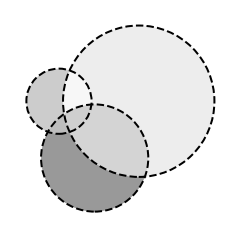

In [92]:
n = 1

f, ax = subplots()
v = venn3([sets[0], sets[1], sets[2]], 
          set_labels = ['MoRFpred', 'DisoRDPbind', 'ANCHOR'],
          set_colors = ['Gray', 'LightGray', 'Black'],
          normalize_to = n)
c = venn3_circles([sets[0], sets[1], sets[2]], 
                  linestyle='dashed',
                  normalize_to = n)

for text in v.set_labels:
    text.set_fontsize(20)
    text.set_visible(False)
for text in v.subset_labels:
    text.set_fontsize(12)
    text.set_visible(False)
    
f, ax = subplots()
v = venn3([sets[0], sets[1], sets[2]], 
          set_labels = ['MoRFpred', 'DisoRDPbind', 'ANCHOR'],
          set_colors = ['Gray', 'LightGray', 'Black'],
          normalize_to = n)
c = venn3_circles([sets[0], sets[1], sets[2]], 
                  linestyle='dashed',
                  normalize_to = n)

savefig('../Figures/VennDiagram3toolsPPI_empty.pdf', format = 'pdf', transparent = True)
savefig('../Figures/VennDiagram3toolsPPI_empty.png', format = 'png', transparent = True, dpi = 300)
show()


#show()

## Overlap with UniProt features

In [94]:
UP_gff = pyb.BedTool('../data/uniprot-organism%3A3702+reviewed%3Ayes+database%3A%28type%3Atair%29.gff')
# Downloaded using the Uniprot linked ID service, http://www.uniprot.org/uploadlists/
mapper = pd.read_csv('../data/uniprot-arabidopsis.tab', sep = '\t').dropna()
mapper['GENE'] = [i.upper() for i in mapper['Gene names  (ordered locus )'].values]
mapper = mapper[['GENE', 'Entry']]
mapper = mapper.set_index('Entry')
mapper = mapper.to_dict()['GENE']

Writing BED file

In [96]:
tab = '\t'
newline = '\n'

fh = open('../data/Uniprot_gff.bed', 'w')

for i in UP_gff:
    unip = i[0]
    db = i[1]
    feat = i[2]
    start = str(i[3])
    end = str(i[4])
    note = i[-2]
    tair_id = mapper[i[0]]
    fh.write(tair_id + tab + start + tab + end + tab + feat + tab + note + newline)
fh.close()

Up_feats_bed = pyb.BedTool('../data/Uniprot_gff.bed')

Loading STR BED file

In [127]:
Repeats = pyb.BedTool('../data/TAIR10_cds_20101214_updated.trf.output.BED')

Making dictionary of "chromsizes" (i.e protein lengths)

In [100]:
# Creating ID list first
string = ''
dictionary = {}
for record in SeqIO.parse('../data/uniprot-arabidopsis.fasta', 'fasta'):
    try:
        up = record.id.split('|')[1]
        dictionary.update({mapper[up] : (1, len(record.seq))})
    except:
        pass

In [102]:
TAIR10_dictionary = {}
for record in SeqIO.parse('../data/TAIR10_coding_sequence_dna.fasta.txt', 'fasta'):
    if len(record.seq) > 20:
        TAIR10_dictionary.update({record.id : (len(record.seq) / 3) - 1})

'prots_to_work_with' should contain proteins of identical length in TAIR10 coding sequence fasta file and that annotated by Uniprot (and also share ID)

In [104]:
prots_to_work_with = []

for key in TAIR10_dictionary:
    if key.split('|')[0] in dictionary.keys():
        transcript = key.split('|')[1]
        mapz = key.split('|')[0]
        if dictionary[mapz][1] != TAIR10_dictionary[key]:
            prots_to_work_with.append(transcript)

Making a subset of the Uniprot GFF with those proteins

In [128]:
subset = Repeats.filter(lambda b:  b.chrom not in prots_to_work_with)
subset.saveas('../data/UP_prots_to_work_with.gff')

<BedTool(../data/UP_prots_to_work_with.gff)>

In [130]:
Repeats = pyb.BedTool('../data/UP_prots_to_work_with.gff')

Removing '.N'

In [133]:
fh = open('../data/UP_prots_to_work_with_cleaned.bed', 'w')
for i in Repeats:
    fh.write(i[0].split('.')[0] + tab + str(i[1]) + tab + str(i[2]) + tab + 'Repeat' + newline)
fh.close()
Repeats = pyb.BedTool('../data/UP_prots_to_work_with_cleaned.bed')
# Setting protein length sizes
Repeats = Repeats.set_chromsizes(dictionary)

Loading GFF with CDS

In [138]:
CDS = pyb.BedTool('../data/TAIR10_GFF3_genes_with_strand.bed.CDS')
CDS_starts = []
for i in CDS:
    CDS_starts.append(int(i[1]))

Intersecting

In [140]:
lst = []
for i in Repeats.intersect(Up_feats_bed, wo = True):
    lst.append(i[7])

In [142]:
def removekey(d, keys):
    r = dict(d)
    for i in keys:
        del r[i]
    return r

In [161]:
D = Counter(lst)

In [162]:
for i in D.keys():
    subset = Up_feats_bed.filter(lambda b:  b.name == i)
    subset.saveas('../data/UP_%s.gff' % i)

In [163]:
chain = pyb.BedTool('../data/UP_chain.gff')
comp_bias = pyb.BedTool('../data/UP_Compositional bias.gff')
Transmembrane = pyb.BedTool('../data/UP_Transmembrane.gff')
SignalPep = pyb.BedTool('../data/UP_Signal peptide.gff')
Disulfite = pyb.BedTool('../data/UP_Disulfide bond.gff')
InitMet = pyb.BedTool('../data/UP_Initiator methionine.gff')
TransPep = pyb.BedTool('../data/UP_Transit peptide.gff')
ZincFinger = pyb.BedTool('../data/UP_Zinc finger.gff')
Rep = pyb.BedTool('../data/UP_Repeat.gff')
Glyc = pyb.BedTool('../data/UP_Glycosylation.gff')
DNA_bind = pyb.BedTool('../data/UP_DNA binding.gff')
NaturalVariant = pyb.BedTool('../data/UP_Natural variant.gff')
CoiledCoil = pyb.BedTool('../data/UP_Coiled coil.gff')
Lipid = pyb.BedTool('../data/UP_Lipidation.gff')
Mutagenesis = pyb.BedTool('../data/UP_Mutagenesis.gff')
Region = pyb.BedTool('../data/UP_Region.gff')
SeqCon = pyb.BedTool('../data/UP_Sequence conflict.gff')
TopDomain = pyb.BedTool('../data/UP_Topological domain.gff')
Domain = pyb.BedTool('../data/UP_Domain.gff')
Motif = pyb.BedTool('../data/UP_Motif.gff')
CrossLink = pyb.BedTool('../data/UP_Cross-link.gff')
Propeptide = pyb.BedTool('../data/UP_Propeptide.gff')
AltSeq = pyb.BedTool('../data/UP_Alternative sequence.gff')
BetaStrand = pyb.BedTool('../data/UP_Beta strand.gff')

In [164]:
D

Counter({u'Alternative sequence': 65,
         u'Beta strand': 1,
         u'Chain': 1694,
         u'Coiled coil': 43,
         u'Compositional bias': 1185,
         u'Cross-link': 1,
         u'DNA binding': 4,
         u'Disulfide bond': 6,
         u'Domain': 57,
         u'Glycosylation': 2,
         u'Initiator methionine': 2,
         u'Lipidation': 1,
         u'Modified residue': 4,
         u'Motif': 11,
         u'Mutagenesis': 1,
         u'Natural variant': 13,
         u'Propeptide': 8,
         u'Region': 29,
         u'Repeat': 12,
         u'Sequence conflict': 93,
         u'Signal peptide': 50,
         u'Topological domain': 109,
         u'Transit peptide': 62,
         u'Transmembrane': 24,
         u'Zinc finger': 5})

In [165]:
D = removekey(D, ['Chain', 'Compositional bias', 'Mutagenesis', 'Sequence conflict', 'Alternative sequence', 'Natural variant'])

In [166]:
D

{u'Beta strand': 1,
 u'Coiled coil': 43,
 u'Cross-link': 1,
 u'DNA binding': 4,
 u'Disulfide bond': 6,
 u'Domain': 57,
 u'Glycosylation': 2,
 u'Initiator methionine': 2,
 u'Lipidation': 1,
 u'Modified residue': 4,
 u'Motif': 11,
 u'Propeptide': 8,
 u'Region': 29,
 u'Repeat': 12,
 u'Signal peptide': 50,
 u'Topological domain': 109,
 u'Transit peptide': 62,
 u'Transmembrane': 24,
 u'Zinc finger': 5}

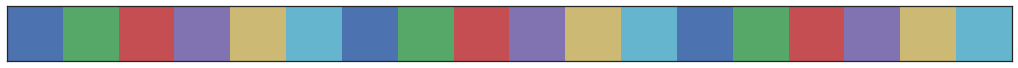

In [167]:
import seaborn as sns
sns.set_style('white')
sns.palplot(sns.color_palette("deep", 18))
show()

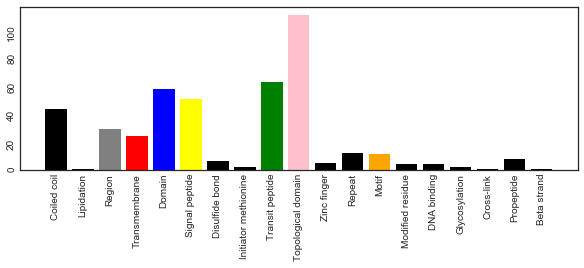

In [168]:
fix, ax = subplots(figsize = (10,3))
bar(range(len(D)), D.values(), align = 'center', color = ['black', 'black', 'Gray', 'Red', 'Blue', 'Yellow', 'Black',
                                                          'black', 'Green', 'Pink', 'black', 'black', 'Orange', 'black',
                                                          'black', 'black', 'black', 'black'])
xticks(range(len(D)), D.keys())
xticks(rotation = 90)
yticks(rotation = 90)
ylim(0,)
show()

In [170]:
def intersect_clean_and_plot(a,b, color, name):
    tab = '\t'
    newline = '\n'
    
    # Getting info from 'Note'
    
    fh = open('../data/notes_bed', 'w')
    for i in b:
        if i[4] != '.':
            note = i[4].split('=')[1].split(';')[0]
            fh.write(i[0] + tab + i[1] + tab + i[2] + tab + note + newline)
        else:
            fh.write(i[0] + tab + i[1] + tab + i[2] + tab + i[3] + newline)
    fh.close()
    
    b = pyb.BedTool('../data/notes_bed')
    
    intersect = a.intersect(b, wo = True)

    uniq_lines = []
    for i in set(list(str(intersect).split('\n'))):
        if i != '':
            uniq_lines.append(i)

    feats = []
    for i in uniq_lines:
        #print i.split('\t')[0]
        try:
            feats.append(i.split('\t')[-2])
        except:
            pass

    feats = [w.replace('Helical%3B Name%3D6', 'Helical') for w in feats]
    feats = [w.replace('Helical%3B Signal-anchor for type II membrane protein', 'Helical; Signal-anchor for type II membrane protein') for w in feats]
    feats = [w.replace('Nuclear localization signal 1', 'Nuclear localization signal') for w in feats]
    feats = [w.replace('Protein kinase', 'Protein kinase domain') for w in feats]

    #print feats
    D = Counter(feats)

    bar(range(len(D)), D.values(), align = 'center', color = color, edgecolor = 'Black')
    xticks(range(len(D)), D.keys())
    xticks(rotation = 90)
    yticks(rotation = 90)
    #ylim(0,200)
    #print intersect
    savefig('../Figures/%s.pdf' % name, type = 'pdf', transparent = True)
    savefig('../Figures/%s.png' % name, type = 'png', transparent = True, dpi = 300)
    show()

## Supplementary Figure 3a.

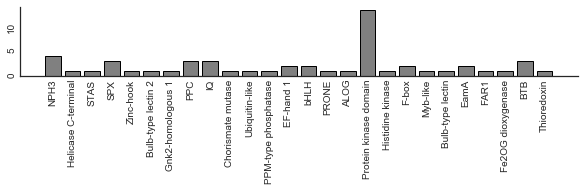

In [171]:
fig, ax = subplots(figsize = (10,12))
gcf().subplots_adjust(bottom=0.8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
intersect_clean_and_plot(Repeats, Domain, 'Gray', 'Domain')

Doing stats for each feature

In [172]:
features = [chain, comp_bias, Transmembrane, SignalPep, Disulfite, InitMet, TransPep, ZincFinger,
            Rep, Glyc, DNA_bind, NaturalVariant, CoiledCoil, Lipid, Mutagenesis, Region, SeqCon,
            TopDomain, Domain, Motif, CrossLink, Propeptide, AltSeq, BetaStrand]

In [ ]:
for feat in features:
    print Repeats.randomstats(feat, 1000)

Saving results in dictionaries

In [173]:
a = {'frac randomized below actual': 0.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 0.0, 'normalized': 0.48113682092555332, 'iterations': 1000, 'median randomized': 3976.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_chain.gff', 'actual': 1913, 'lower_2.5th': 3933.0, 'self': 4471, 'upper_97.5th': 4017.0, 'other': 14116, 'frac randomized above actual': 1.0, '../analysis/UniProt_overlap/UP_chain.gff': 14116}
b = {'frac randomized below actual': 1.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 100.0, 'normalized': 10.916666666666666, 'iterations': 1000, 'median randomized': 120.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Compositional bias.gff', 'actual': 1310, 'upper_97.5th': 143.0, 'self': 4471, 'other': 4458, 'frac randomized above actual': 0.0, 'lower_2.5th': 98.0, '../analysis/UniProt_overlap/UP_Compositional bias.gff': 4458}
c = {'frac randomized below actual': 0.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 0.0, 'normalized': 0.096000000000000002, 'iterations': 1000, 'median randomized': 250.0, '../analysis/UniProt_overlap/UP_Transmembrane.gff': 14722, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Transmembrane.gff', 'actual': 24, 'upper_97.5th': 280.0, 'self': 4471, 'other': 14722, 'frac randomized above actual': 1.0, 'lower_2.5th': 221.0}
d = {'frac randomized below actual': 1.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 100.0, 'normalized': 1.5, 'iterations': 1000, 'median randomized': 34.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Signal peptide.gff', 'actual': 51, 'upper_97.5th': 45.0, 'self': 4471, 'other': 2114, 'frac randomized above actual': 0.0, '../analysis/UniProt_overlap/UP_Signal peptide.gff': 2114, 'lower_2.5th': 23.0}
e = {'frac randomized below actual': 0.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 0.0, 'normalized': 0.072727272727272724, 'iterations': 1000, 'median randomized': 55.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Disulfide bond.gff', 'actual': 4, 'upper_97.5th': 69.0, '../analysis/UniProt_overlap/UP_Disulfide bond.gff': 2862, 'other': 2862, 'frac randomized above actual': 1.0, 'lower_2.5th': 41.0, 'self': 4471}
f = {'frac randomized below actual': 0.76200000000000001, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 84.799999999999997, 'normalized': 2.0, 'iterations': 1000, 'median randomized': 1.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Initiator methionine.gff', 'actual': 2, 'upper_97.5th': 3.0, 'self': 4471, 'other': 702, 'frac randomized above actual': 0.067000000000000004, '../analysis/UniProt_overlap/UP_Initiator methionine.gff': 702, 'lower_2.5th': 0.0}
g = {'../analysis/UniProt_overlap/UP_Transit peptide.gff': 1594, 'frac randomized below actual': 0.99099999999999999, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 99.099999999999994, 'normalized': 1.3269230769230769, 'iterations': 1000, 'median randomized': 52.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Transit peptide.gff', 'actual': 69, 'upper_97.5th': 66.0, 'self': 4471, 'other': 1594, 'frac randomized above actual': 0.0089999999999999993, 'lower_2.5th': 39.0}
h = {'frac randomized below actual': 0.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 0.0, 'normalized': 0.15625, 'iterations': 1000, 'median randomized': 32.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Zinc finger.gff', 'actual': 5, 'upper_97.5th': 43.0, 'self': 4471, '../analysis/UniProt_overlap/UP_Zinc finger.gff': 1099, 'other': 1099, 'frac randomized above actual': 1.0, 'lower_2.5th': 21.0}
i = {'frac randomized below actual': 0.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, '../analysis/UniProt_overlap/UP_Repeat.gff': 13383, 'percentile': 0.0, 'normalized': 0.034364261168384883, 'iterations': 1000, 'median randomized': 291.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Repeat.gff', 'actual': 10, 'upper_97.5th': 325.0, 'self': 4471, 'other': 13383, 'frac randomized above actual': 1.0, 'lower_2.5th': 258.0}
j = {'frac randomized below actual': 0.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 0.0, 'normalized': 0.04878048780487805, 'iterations': 1000, 'median randomized': 41.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Glycosylation.gff', 'actual': 2, 'upper_97.5th': 53.0, 'self': 4471, '../analysis/UniProt_overlap/UP_Glycosylation.gff': 7360, 'other': 7360, 'frac randomized above actual': 1.0, 'lower_2.5th': 28.0}
k = {'frac randomized below actual': 0.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 0.0, 'normalized': 0.12820512820512819, 'iterations': 1000, 'median randomized': 39.0, '../analysis/UniProt_overlap/UP_DNA binding.gff': 975, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_DNA binding.gff', 'actual': 5, 'upper_97.5th': 52.0, 'self': 4471, 'other': 975, 'frac randomized above actual': 1.0, 'lower_2.5th': 27.0}
l = {'frac randomized below actual': 0.98299999999999998, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 98.75, 'normalized': 2.5, 'iterations': 1000, 'median randomized': 4.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Natural variant.gff', '../analysis/UniProt_overlap/UP_Natural variant.gff': 765, 'actual': 10, 'upper_97.5th': 9.0, 'self': 4471, 'other': 765, 'frac randomized above actual': 0.0089999999999999993, 'lower_2.5th': 1.0}
m = {'../analysis/UniProt_overlap/UP_Coiled coil.gff': 1346, 'frac randomized below actual': 0.0089999999999999993, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 1.0999999999999999, 'normalized': 0.7384615384615385, 'iterations': 1000, 'median randomized': 65.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Coiled coil.gff', 'actual': 48, 'upper_97.5th': 81.0, 'self': 4471, 'other': 1346, 'frac randomized above actual': 0.98799999999999999, 'lower_2.5th': 50.0}
n = {'frac randomized below actual': 0.26000000000000001, '../analysis/UniProt_overlap/UP_Lipidation.gff': 470, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 42.549999999999997, 'normalized': 1.0, 'iterations': 1000, 'median randomized': 1.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Lipidation.gff', 'actual': 1, 'upper_97.5th': 4.0, 'self': 4471, 'other': 470, 'frac randomized above actual': 0.40999999999999998, 'lower_2.5th': 0.0}
o = {'frac randomized below actual': 0.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 0.0, 'normalized': 0.050000000000000003, 'iterations': 1000, 'median randomized': 20.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Mutagenesis.gff', 'actual': 1, 'upper_97.5th': 29.0, 'self': 4471, 'other': 4240, 'frac randomized above actual': 1.0, '../analysis/UniProt_overlap/UP_Mutagenesis.gff': 4240, 'lower_2.5th': 13.0}
p = {'frac randomized below actual': 0.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, '../analysis/UniProt_overlap/UP_Region.gff': 3594, 'percentile': 0.0, 'normalized': 0.22480620155038761, 'iterations': 1000, 'median randomized': 129.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Region.gff', 'actual': 29, 'upper_97.5th': 154.0, 'self': 4471, 'other': 3594, 'frac randomized above actual': 1.0, 'lower_2.5th': 107.0}
q = {'frac randomized below actual': 1.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 100.0, 'normalized': 1.8085106382978724, 'iterations': 1000, 'median randomized': 47.0, '../analysis/UniProt_overlap/UP_Sequence conflict.gff': 9610, 'file_b': '../analysis/UniProt_overlap/UP_Sequence conflict.gff', 'actual': 85, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'self': 4471, 'upper_97.5th': 60.0, 'other': 9610, 'frac randomized above actual': 0.0, 'lower_2.5th': 34.0}
r = {'../analysis/UniProt_overlap/UP_Topological domain.gff': 5982, 'frac randomized below actual': 0.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 0.0, 'normalized': 0.32581453634085211, 'iterations': 1000, 'median randomized': 399.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Topological domain.gff', 'actual': 130, 'upper_97.5th': 438.0, 'self': 4471, 'other': 5982, 'frac randomized above actual': 1.0, 'lower_2.5th': 362.0}
s = {'frac randomized below actual': 0.0, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 0.0, 'normalized': 0.089333333333333334, 'iterations': 1000, 'median randomized': 750.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Domain.gff', 'actual': 67, 'upper_97.5th': 801.04999999999995, '../analysis/UniProt_overlap/UP_Domain.gff': 8505, 'other': 8505, 'frac randomized above actual': 1.0, 'lower_2.5th': 701.0, 'self': 4471}
t = {'frac randomized below actual': 0.29599999999999999, '../analysis/UniProt_overlap/UP_Motif.gff': 1804, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 33.350000000000001, 'normalized': 0.875, 'iterations': 1000, 'median randomized': 16.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Motif.gff', 'actual': 14, 'upper_97.5th': 23.0, 'self': 4471, 'other': 1804, 'frac randomized above actual': 0.63, 'lower_2.5th': 8.0}
u = {'frac randomized below actual': 0.40500000000000003, '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed': 4471, 'percentile': 59.199999999999996, 'normalized': 1.0, 'iterations': 1000, '../analysis/UniProt_overlap/UP_Cross-link.gff': 170, 'median randomized': 1.0, 'file_a': '../analysis/UniProt_overlap/UP_prots_to_work_with_cleaned.bed', 'file_b': '../analysis/UniProt_overlap/UP_Cross-link.gff', 'actual': 1, 'upper_97.5th': 3.0, 'self': 4471, 'other': 170, 'frac randomized above actual': 0.222, 'lower_2.5th': 0.0}

In [174]:
Up_dict = {}
for res in [a, b, c, d, e, f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u]:
    feat = res['file_b'].split('_')[2].split('.')[0]
    if feat not in ['chain', 'Topological domain', 'Sequence conflict', 'Region', 'Mutagenesis', 'Lipidation',
                    'Initiator methionine', 'Glycosylation', 'Disulfide bond', 'Cross-link', 
                    'Compositional bias', 'Natural variant']:
        print feat, res['percentile']
        Up_dict.update({feat : res['actual'] / res['median randomized']})

Transmembrane 0.0
Signal peptide 100.0
Transit peptide 99.1
Zinc finger 0.0
Repeat 0.0
DNA binding 0.0
Coiled coil 1.1
Domain 0.0
Motif 33.35


## Supplementary Figure 3b.

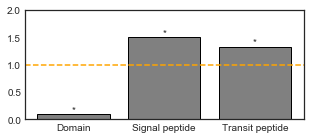

In [176]:
D = Up_dict
D = removekey(D, ['Coiled coil', 'Zinc finger', 'Repeat', 'Motif', 'DNA binding', 'Transmembrane'])
fix, ax = subplots(figsize = (5,4))
bar(range(len(D)), D.values(), align = 'center', color = 'Gray', edgecolor = 'Black')
axhline(1, color = 'orange', ls = 'dashed')
xticks(range(len(D)), D.keys())

rects = ax.patches
labels = ['*', '*', '*']

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')

ylim(0, 2)
gcf().subplots_adjust(bottom=0.5)
savefig('../Figures/Enrinchment_UniProt_features.pdf', type = 'pdf', transparent = True)
savefig('../Figures/Enrinchment_UniProt_features.png', type = 'png', transparent = True, dpi = 300)


show()